In [1]:
# import Noise class from detprocess
from detprocess import Noise, Template
import scipy.fft as fft
import scipy.signal as signal
import scipy.stats as stats
import scipy.special as special
import numpy as np
import qetpy as qp
from qetpy.core.didv._uncertainties_didv import get_power_noise_with_uncertainties, get_dPdI_with_uncertainties
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
from pytesdaq.io import FilterH5IO
mpl.rcParams['font.size'] = 16
import glob
from pytesdaq.io.hdf5 import H5Reader
import time
from scipy.interpolate import interp1d
import detprocess

# Create evaporation template

### Load existing CSDs and template

In [2]:
template = Template(verbose=True)

template.load_hdf5('/home/vvelan/OF_Development/detprocess/scripts/processing_configs/joanna_filter.hdf5')

template.describe()

INFO: Loading filter data from file /home/vvelan/OF_Development/detprocess/scripts/processing_configs/joanna_filter.hdf5
List of channels: ['CPD2', 'CPD1|CPD2', 'CPD1']

Channel CPD2:
 * Tag "default":
    psd: pandas.Series (12500,)
    template: pandas.Series (12500,)

Channel CPD1|CPD2:
 * Tag "default":
    csd: 3D numpy.array  (2, 2, 12500)
 * Tag "freqs_default":
    csd: pandas.Series (12500,)
 * Tag "scintillation":
    template: 3D numpy.array  (2, 2, 12500)

Channel CPD1:
 * Tag "default":
    psd: pandas.Series (12500,)
    template: pandas.Series (12500,)


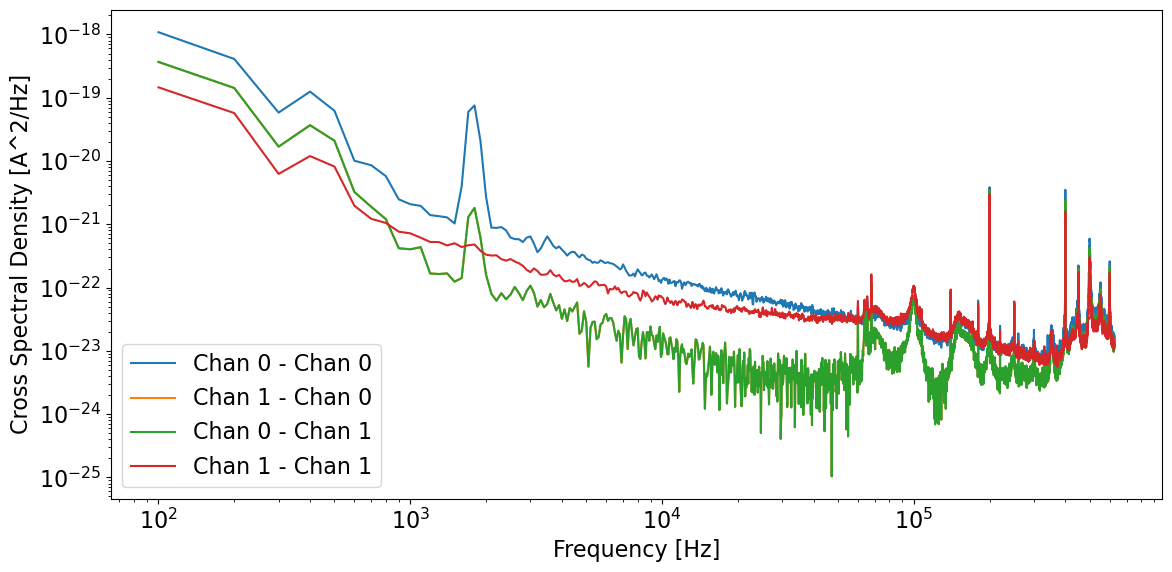

In [3]:
csd, _, _ = template.get_csd('CPD1|CPD2', fold=False, return_metadata=True, tag='default')
freqs_csd, _, _ = template.get_csd('CPD1|CPD2', fold=False, return_metadata=True, tag='freqs_default')
csd[:,:,0] = np.zeros((2,2))

# FDS = Fourier Domain Shifted
csd_fds = fft.fftshift(csd, axes=2)
freqs_fds = fft.fftshift(freqs_csd)
dfreq = np.diff(freqs_fds)[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

cut = freqs_fds > 0
ax.plot(freqs_fds[cut], np.sqrt(csd_fds[0,0][cut].real**2 + csd_fds[0,0][cut].imag**2), label='Chan 0 - Chan 0')
ax.plot(freqs_fds[cut], np.sqrt(csd_fds[1,0][cut].real**2 + csd_fds[1,0][cut].imag**2), label='Chan 1 - Chan 0')
ax.plot(freqs_fds[cut], np.sqrt(csd_fds[0,1][cut].real**2 + csd_fds[0,1][cut].imag**2), label='Chan 0 - Chan 1')
ax.plot(freqs_fds[cut], np.sqrt(csd_fds[1,1][cut].real**2 + csd_fds[1,1][cut].imag**2), label='Chan 1 - Chan 1')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Cross Spectral Density [A^2/Hz]')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left')

fig.tight_layout()
fig.show()


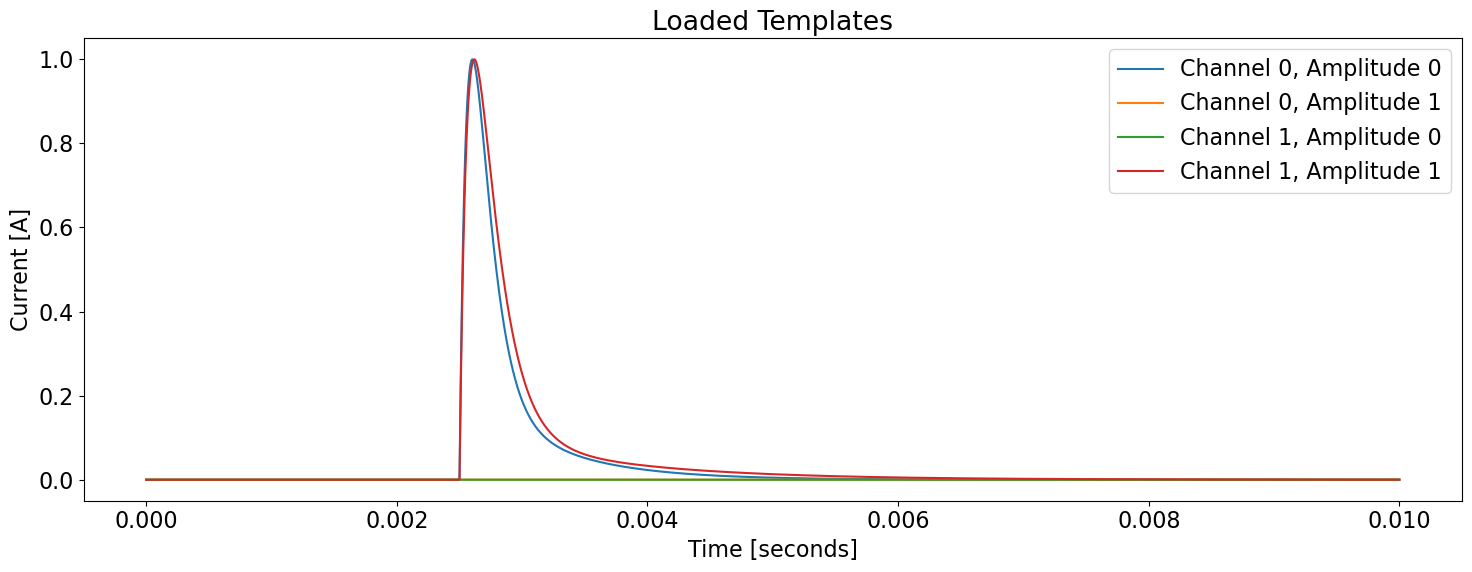

In [ ]:
# td = Time Domain
templates_td, t_sec_template, metadata = template.get_template('CPD1|CPD2', return_metadata=True, tag='scintillation')
n_channels, m_amplitudes, f_freqs = templates_td.shape
t_times = len(t_sec_template)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

for i in range(n_channels):
    for j in range(m_amplitudes):
        ax.plot(t_sec_template, templates_td[i,j], label=f'Channel {i}, Amplitude {j}')
        
ax.legend(loc='upper right')
ax.set_title('Loaded Templates')
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Current [A]')
fig.tight_layout()
fig.show()

### Add an evaporation template (just make one up)

3125 2.5


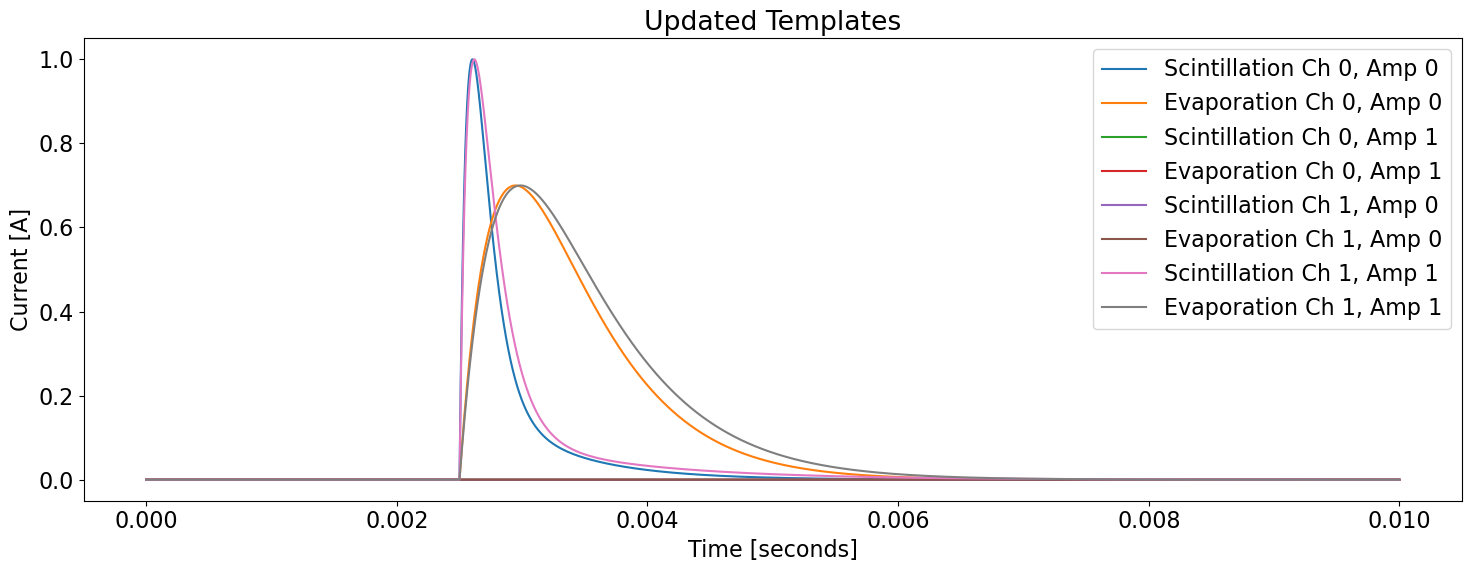

In [5]:
pretrigger_samples = np.where(templates_td[0,0] == 0)[0][-1]
pretrigger_ms = pretrigger_samples * 0.8e-3
print(pretrigger_samples, pretrigger_ms)

evap_1 = (np.exp(-t_sec_template / 500e-6) - np.exp(-t_sec_template / 400e-6))
evap_1 *= (0.7 / np.max(evap_1))
evap_1 = np.roll(evap_1, pretrigger_samples)
evap_1[:pretrigger_samples] = 0

evap_2 = (np.exp(-t_sec_template / 600e-6) - np.exp(-t_sec_template / 400e-6))
evap_2 *= (0.7 / np.max(evap_2))
evap_2 = np.roll(evap_2, pretrigger_samples)
evap_2[:pretrigger_samples] = 0

templates_evap = np.zeros((n_channels, m_amplitudes, t_times))
templates_evap[0,0] = evap_1
templates_evap[1,1] = evap_2

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

for i in range(n_channels):
    for j in range(m_amplitudes):
        ax.plot(t_sec_template, templates_td[i,j], label=f'Scintillation Ch {i}, Amp {j}')
        ax.plot(t_sec_template, templates_evap[i,j], label=f'Evaporation Ch {i}, Amp {j}')

ax.set_title('Updated Templates')
ax.legend(loc='upper right')
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Current [A]')
fig.tight_layout()
fig.show()

### Save new template to HDF5

In [6]:
template.set_template('CPD1|CPD2', templates_evap,
                     sample_rate=1.25e6,
                     pretrigger_length_msec=pretrigger_ms,
                     pretrigger_length_samples=pretrigger_samples,
                     metadata=metadata,
                     tag='evaporation')

if False: # Disable/enable this to save a new filter file
    template.save_hdf5('UMass_filter_scint_evap.hdf5', overwrite=True)


# Generate simulated noise data

In [7]:
template = Template(verbose=True)

template.load_hdf5('UMass_filter_scint_evap.hdf5')

template.describe()

INFO: Loading filter data from file UMass_filter_scint_evap.hdf5
List of channels: ['CPD2', 'CPD1|CPD2', 'CPD1']

Channel CPD2:
 * Tag "default":
    psd: pandas.Series (12500,)
    template: pandas.Series (12500,)

Channel CPD1|CPD2:
 * Tag "default":
    csd: 3D numpy.array  (2, 2, 12500)
 * Tag "freqs_default":
    csd: pandas.Series (12500,)
 * Tag "evaporation":
    template: 3D numpy.array  (2, 2, 12500)
 * Tag "scintillation":
    template: 3D numpy.array  (2, 2, 12500)

Channel CPD1:
 * Tag "default":
    psd: pandas.Series (12500,)
    template: pandas.Series (12500,)


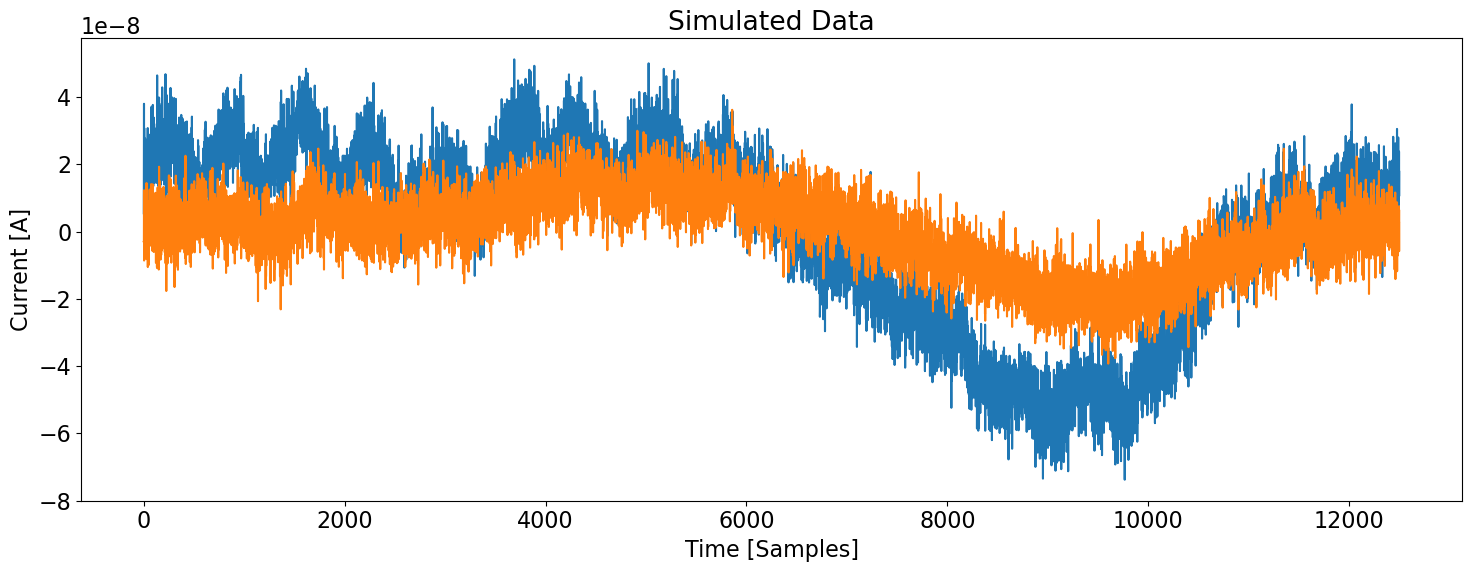

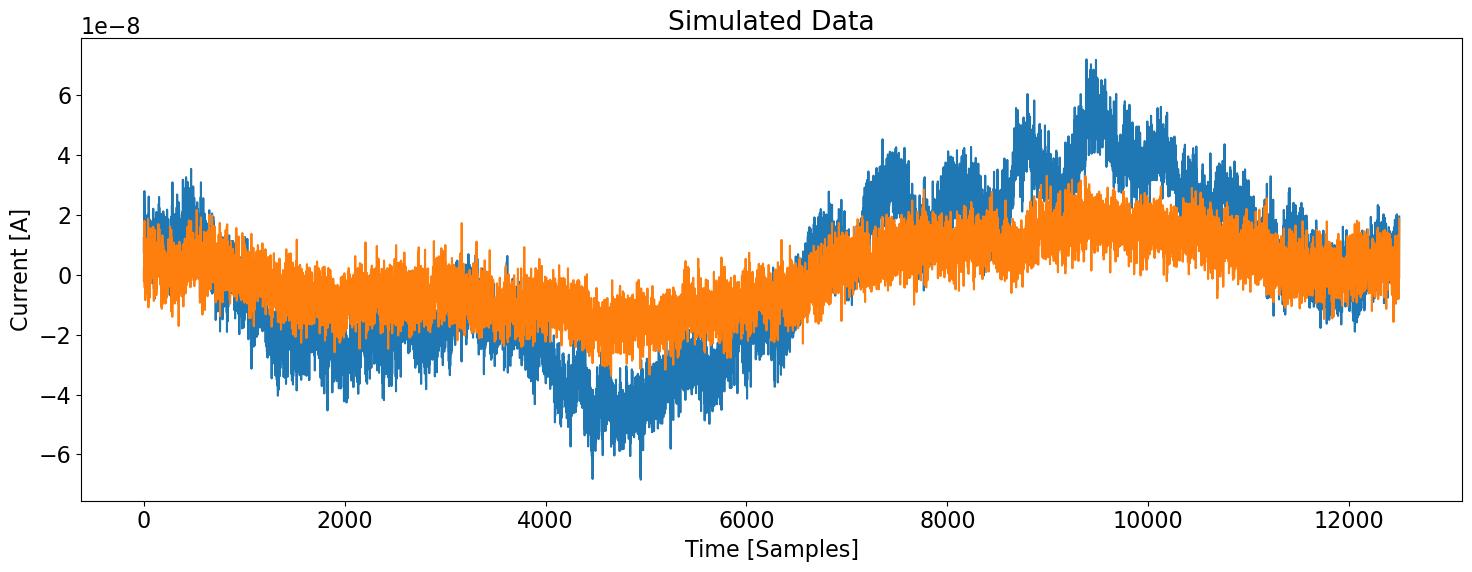

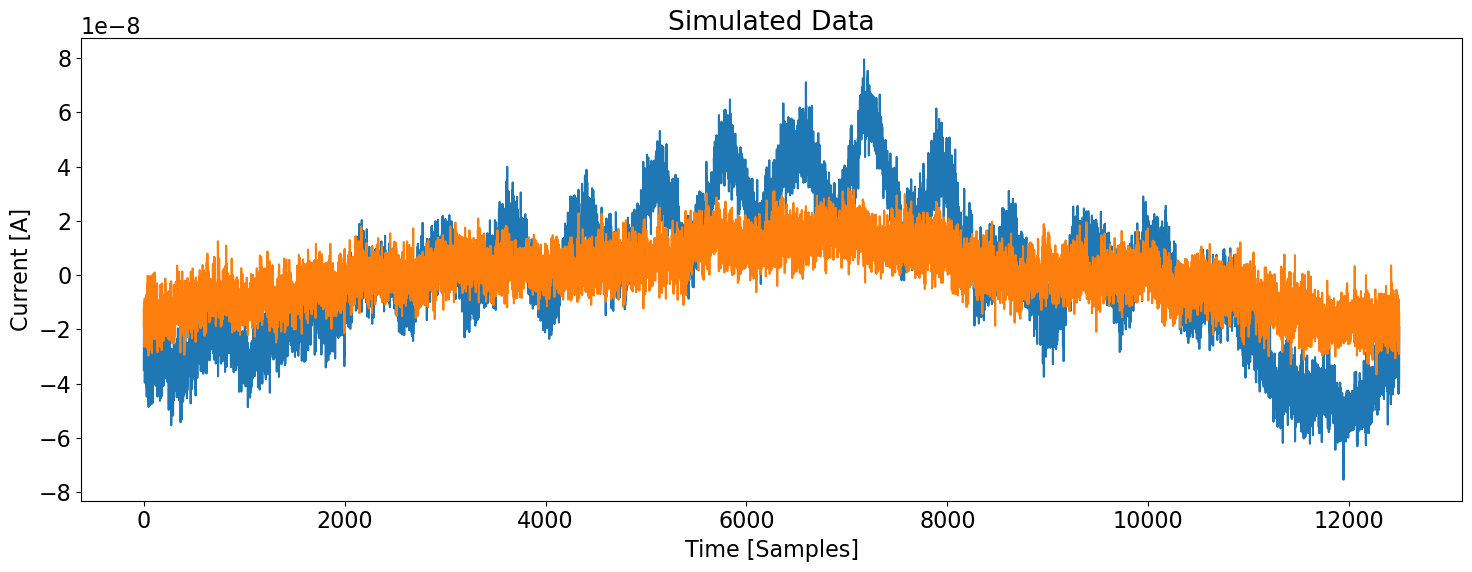

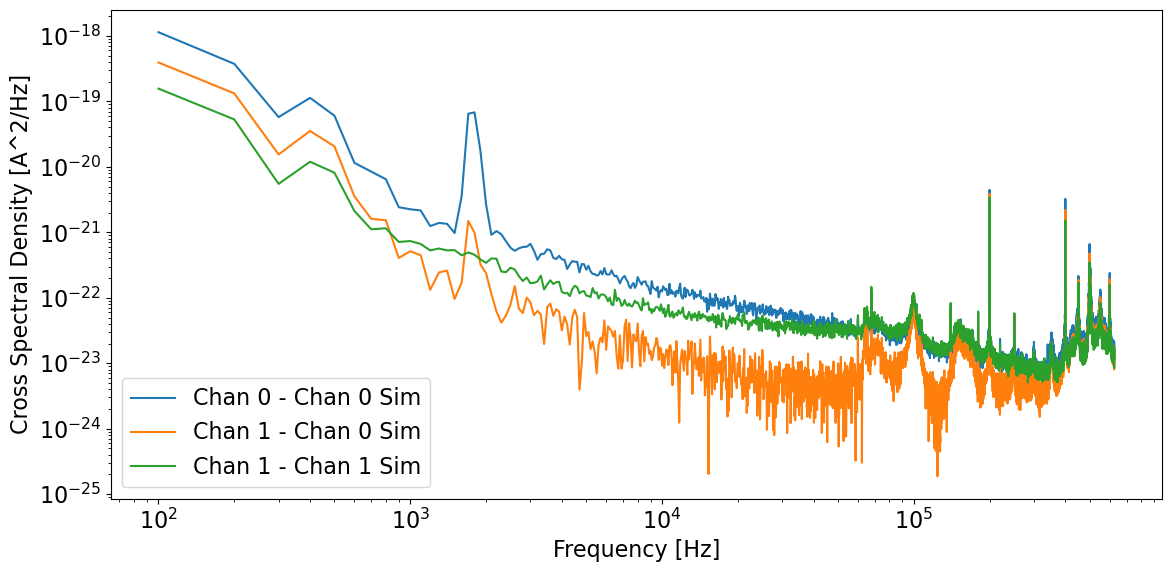

In [8]:
# Simulate noise traces
n_traces = 100
simulated_noise = qp.gen_noise(csd, 1.25e6, n_traces)

# Plot a few traces
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.plot(simulated_noise[i][0])
    ax.plot(simulated_noise[i][1])
    ax.set_title('Simulated Data')
    ax.set_xlabel('Time [Samples]')
    ax.set_ylabel('Current [A]')
    fig.tight_layout()
    fig.show()

# Calculate and plot the cross spectral density of the simulated data
freqs_csd_sim, csd_sim = qp.calc_csd(simulated_noise, fs=1.25e6)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

cut = freqs_csd_sim > 0
ax.plot(freqs_csd_sim[cut], np.abs(csd_sim[0,0][cut]), label='Chan 0 - Chan 0 Sim')
ax.plot(freqs_csd_sim[cut], np.abs(csd_sim[1,0][cut]), label='Chan 1 - Chan 0 Sim')
ax.plot(freqs_csd_sim[cut], np.abs(csd_sim[1,1][cut]), label='Chan 1 - Chan 1 Sim')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Cross Spectral Density [A^2/Hz]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left')

fig.tight_layout()
fig.show()


# Simulate pulses, and fit them with a 2x2x1 OF Trigger

### Load data into a single long datastream

In [9]:
traces_td = np.copy(np.concatenate( [simulated_noise[i] for i in range(12)] , axis=1))
print(f'Shape of simulated observation is {traces_td.shape}')

Shape of simulated observation is (2, 150000)


### Convert template into the format we want

In [10]:
template = Template(verbose=True)
template.load_hdf5('UMass_filter_scint_evap.hdf5')

csd, _, _ = template.get_csd('CPD1|CPD2', fold=False, return_metadata=True, tag='default')
template_2x2_scint, t_sec_template, _ = template.get_template('CPD1|CPD2', return_metadata=True, tag='scintillation')
template_2x2_evap, _, _ = template.get_template('CPD1|CPD2', return_metadata=True, tag='evaporation')

templates_td = np.zeros((2, 2, t_sec_template.size))
templates_td[0,0] = template_2x2_scint[0,0]
templates_td[1,0] = template_2x2_scint[1,1]
templates_td[0,1] = template_2x2_evap[0,0]
templates_td[1,1] = template_2x2_evap[1,1]
templates_td *= 3e-8

n_channels, m_amplitudes, f_freqs = templates_td.shape
t_times = len(t_sec_template)

INFO: Loading filter data from file UMass_filter_scint_evap.hdf5


### Add some pulses on top of the noise

In [11]:
traces_td[:, 20000:20000+t_times] += templates_td[:,0] # Scintillation in both channels
traces_td[:, 20000:20000+t_times] += templates_td[:,1] # Evaporation in both channels

traces_td[:, 70000:70000+t_times] += templates_td[:,0] * 0.5 # Scintillation in both channels
traces_td[:, 70000:70000+t_times] += templates_td[:,1] * 2 # Evaporation in both channels

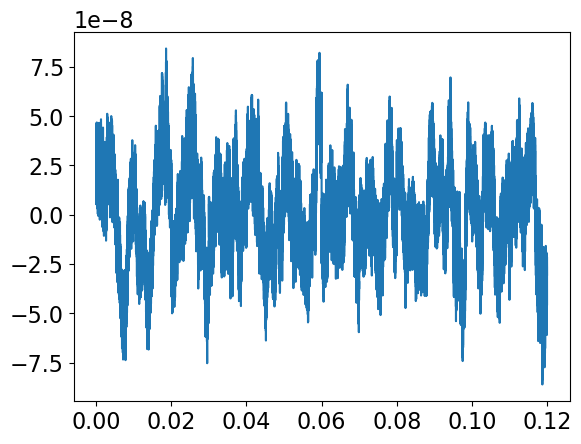

In [12]:
t_arr = np.arange(traces_td.shape[1]) * 0.8e-6
plt.plot(t_arr, traces_td[0])

### Use a 2x2x1 trigger to identify the pulses

In [13]:
oftrigger = detprocess.OptimumFilterTrigger('CPD1|CPD2', 1.25e6, templates_td, csd, pretrigger_samples=3125)

oftrigger.update_trace(traces_td)
oftrigger.find_triggers(5, pileup_window_msec=8)

oftrigger.get_trigger_data_df()

#,trigger_delta_chi2,trigger_time,trigger_index,trigger_pileup_window,trigger_threshold_sigma,trigger_type,trigger_amplitude_0,trigger_amplitude_1,trigger_delta_chi2_CPD1|CPD2,trigger_time_CPD1|CPD2,trigger_index_CPD1|CPD2,trigger_pileup_window_CPD1|CPD2,trigger_threshold_sigma_CPD1|CPD2,trigger_type_CPD1|CPD2,trigger_amplitude_0_CPD1|CPD2,trigger_amplitude_1_CPD1|CPD2,trigger_channel
0,444.553,0.018508,23135,10000,5,4,1.07334,0.81548,444.553,0.018508,23135,10000,5,4,1.07334,0.81548,CPD1|CPD2
1,49.2844,0.029976,37470,10000,5,4,0.465183,-0.154217,49.2844,0.029976,37470,10000,5,4,0.465183,-0.154217,CPD1|CPD2
2,63.2424,0.0399768,49971,10000,5,4,0.433595,0.225276,63.2424,0.0399768,49971,10000,5,4,0.433595,0.225276,CPD1|CPD2
3,444.848,0.0584984,73123,10000,5,4,0.45643,1.99911,444.848,0.0584984,73123,10000,5,4,0.45643,1.99911,CPD1|CPD2
4,75.645,0.0699736,87467,10000,5,4,0.398749,0.446784,75.645,0.0699736,87467,10000,5,4,0.398749,0.446784,CPD1|CPD2


# Simulate pulses, and fit them with a 2x2x2 OF Trigger


### Reload data into a single long datastream

In [14]:
traces_td = np.copy(np.concatenate( [simulated_noise[i] for i in range(12, 24)] , axis=1))
print(f'Shape of simulated observation is {traces_td.shape}')

Shape of simulated observation is (2, 150000)


### Add some pulses on top of the noise, but now with time separation

In [15]:
traces_td[:, 20000:20000+t_times] += templates_td[:,0] # Scintillation in both channels
traces_td[:, 20100:20100+t_times] += templates_td[:,1] # Evaporation in both channels, 100 samples later

traces_td[:, 70000:70000+t_times] += templates_td[:,0] * 0.5 # Scintillation in both channels
traces_td[:, 70600:70600+t_times] += templates_td[:,1] * 2 # Evaporation in both channels, 600 samples later

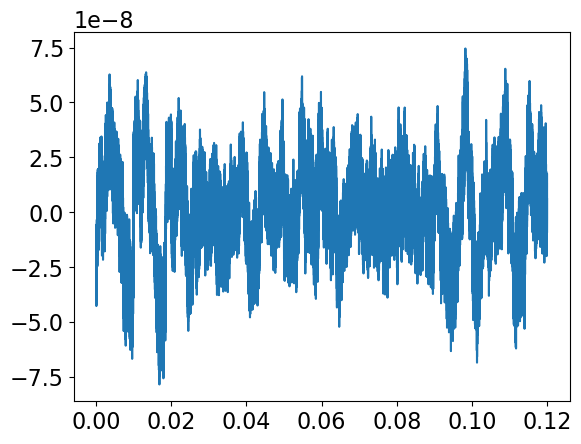

In [16]:
t_arr = np.arange(traces_td.shape[1]) * 0.8e-6
plt.plot(t_arr, traces_td[0])

### Try to fit with 2x2x1 trigger

In [17]:
oftrigger = detprocess.OptimumFilterTrigger('CPD1|CPD2', 1.25e6, templates_td, csd, pretrigger_samples=3125)

oftrigger.update_trace(traces_td)
oftrigger.find_triggers(10, pileup_window_msec=8)

oftrigger.get_trigger_data_df()

#,trigger_delta_chi2,trigger_time,trigger_index,trigger_pileup_window,trigger_threshold_sigma,trigger_type,trigger_amplitude_0,trigger_amplitude_1,trigger_delta_chi2_CPD1|CPD2,trigger_time_CPD1|CPD2,trigger_index_CPD1|CPD2,trigger_pileup_window_CPD1|CPD2,trigger_threshold_sigma_CPD1|CPD2,trigger_type_CPD1|CPD2,trigger_amplitude_0_CPD1|CPD2,trigger_amplitude_1_CPD1|CPD2,trigger_channel
0,310.916,0.0184888,23111,10000,10,4,0.580979,1.36349,310.916,0.0184888,23111,10000,10,4,0.580979,1.36349,CPD1|CPD2
1,267.032,0.0589088,73636,10000,10,4,-0.639756,2.09209,267.032,0.0589088,73636,10000,10,4,-0.639756,2.09209,CPD1|CPD2


# Now try with a 2x2x2 trigger

In [18]:
oftrigger = detprocess.OptimumFilterTriggerX2('CPD1|CPD2', 1.25e6, templates_td, csd, pretrigger_samples=3125,
                                              template_group_ids=[0, 1], delta_t_list=np.arange(0, 1000, 50))

oftrigger.update_trace(traces_td)
oftrigger.find_triggers(10, pileup_window_msec=8)

oftrigger.get_trigger_data_df()


#,trigger_delta_chi2,trigger_time,trigger_index,trigger_pileup_window,trigger_threshold_sigma,trigger_type,trigger_amplitude_0,trigger_amplitude_1,trigger_delta_chi2_CPD1|CPD2,trigger_time_CPD1|CPD2,trigger_index_CPD1|CPD2,trigger_pileup_window_CPD1|CPD2,trigger_threshold_sigma_CPD1|CPD2,trigger_type_CPD1|CPD2,trigger_amplitude_0_CPD1|CPD2,trigger_amplitude_1_CPD1|CPD2,trigger_channel
0,312.098,0.0184888,23111,10000,10,4,1.03541,1.36349,312.098,0.0184888,23111,10000,10,4,1.03541,1.36349,CPD1|CPD2
1,344.326,0.058496,73120,10000,10,4,0.564143,2.145,344.326,0.058496,73120,10000,10,4,0.564143,2.145,CPD1|CPD2
